In [1]:
import numpy as np
from helpers import *
from implementations import *
from validation import *
from processing import preprocess_data
from metrics import *
from plots import plot_class_imbalance
import math as math

[-1  1]
[299160  28975]


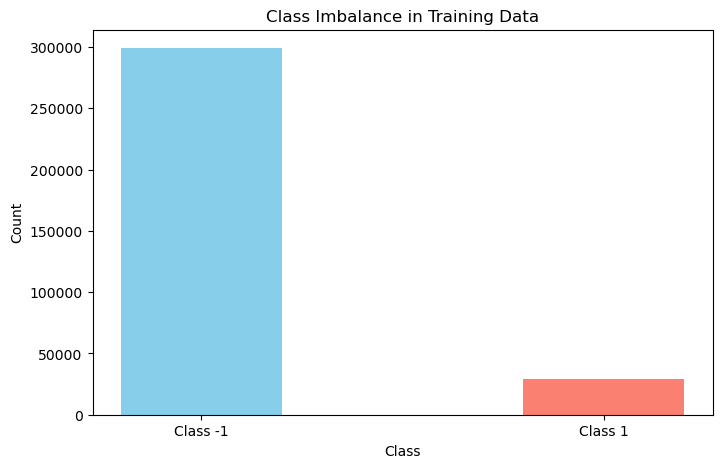

In [2]:
# Load the data and preprocess it
# We keep a copy of the original imbalanced data to use it as a validation set.
data_path = "./data/dataset_to_release/"
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path)
xtrain, ytrain, xtest, imbalanced_x = preprocess_data(x_train, y_train, x_test)

# Convert labels from {-1, 1} to {0, 1}
ytrain_01 = ytrain.copy()
ytrain_01[ytrain_01 == -1] = 0

# plot original data class imbalance
plot_class_imbalance(y_train)

# Ridge regression
Ridge regression on raw data is poorly effective. It generates many computational issues like for example singularity of the data set which mean that matrix inverse does not exist.

We never the less trained our undersampled and cleaned data with a ridge regression and  obtained satisfying results.

The process steps are :
- tuning the λ parameter : find the one that minimizes the loss
- fit the model
- tuning the threshold in order to optimize the f2 score

In [3]:
# Tune parameter lambda for ridge regression
lambdas = thresholds=np.linspace(1e-5, 1, 101)
best_lambda = 0.1
min_loss = math.inf
for lambda_ in lambdas:
    w,loss = ridge_regression(ytrain_01,xtrain,lambda_)
    if loss < min_loss:
        min_loss = loss
        best_lambda = lambda_
print(f"Best lambda : {best_lambda} with loss {loss}")

Best lambda : 1e-05 with loss 0.08508131983885268


In [4]:
w,loss = ridge_regression(ytrain_01,xtrain,best_lambda)

print("Accuracy on undersampled data: ", accuracy(xtrain, ytrain, w))

best_threshold = find_best_threshold(xtrain,ytrain,w)
print(f"F1 score on undersampled data with tuned threshold:  {f1(xtrain, ytrain, w,best_threshold)} with threshold {best_threshold}")
print(f"F1 score on undersampled data:  {f1(xtrain, ytrain, w,0.5)} with threshold {0.5} \n")

print("original data accuracy: ", accuracy(imbalanced_x, y_train, w))

best_threshold = find_best_threshold(imbalanced_x,y_train,w)
print(f"original data f1 with tuned threshold: {f1(imbalanced_x, y_train, w,best_threshold)} with threshold {best_threshold}")
print(f"original data f1: {f1(imbalanced_x, y_train, w,0.5)} with threshold {0.5}")


Accuracy on undersampled data:  0.5451596203623814
F1 score on undersampled data with tuned threshold:  0.8001379115798711 with threshold 0.6053511705685619
F1 score on undersampled data:  0.692470799640611 with threshold 0.5 

original data accuracy:  0.9147637405336219
original data f1 with tuned threshold: 0.43075512900008095 with threshold 0.6622073578595318
original data f1: 0.1795132979714538 with threshold 0.5


# Logistic regression

In this section we will train our pre-processed data with logistic regression.
The process steps are the following:
- tune parameter the parameter γ
- train the model
- tune the threshold for optimal f1 score

In [5]:
# Train the model with the best hyperparameters
init_w = np.zeros(xtrain.shape[1])
val_max_iters = 50
# Tune parameter lambda for ridge regression
gammas = thresholds=np.linspace(1e-6, 1, 101)
best_gamma = 0.01
min_loss = math.inf
best_w = init_w
for gamma in gammas:
    w,loss = logistic_regression(ytrain_01,xtrain,init_w,val_max_iters,gamma)
    if loss < min_loss:
        min_loss = loss
        best_gamma = gamma
        best_w = w
print(f"Best gamma : {best_gamma} with loss {loss}")

c:\Users\amene\Desktop\mlp\MLprojects_era\helpers.py:185: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Best gamma : 0.02000098 with loss 4.1522525271369926


In [6]:
training_max_iters = 5000
w, loss = logistic_regression(ytrain_01, xtrain,best_w, training_max_iters, best_gamma)
print("Achieved loss: ", loss)

Achieved loss:  1.320999226712524


In [7]:
print("Accuracy on undersampled data: ", accuracy(xtrain, ytrain, w))
best_threshold = find_best_threshold(xtrain,ytrain,w)
print(f"F1 score on undersampled data with tuned threshold:  {f1(xtrain, ytrain, w,best_threshold)} with threshold {best_threshold}")
print(f"F1 score on undersampled data: {f1(xtrain, ytrain, w,0.5)} with threshold {0.5} \n")

print("original data accuracy: ", accuracy(imbalanced_x, y_train, w))
best_threshold = find_best_threshold(imbalanced_x,y_train,w)
print(f"original data f1 with tuned threshold: {f1(imbalanced_x, y_train, w,best_threshold)} with threshold {best_threshold}")
print(f"original data f1: {f1(imbalanced_x, y_train, w,0.5)} with threshold {0.5}")

Accuracy on undersampled data:  0.749404659188956
F1 score on undersampled data with tuned threshold:  0.7698282531332199 with threshold 0.05016722408026756
F1 score on undersampled data: 0.7531145391172309 with threshold 0.5 

original data accuracy:  0.7790543526292532
original data f1 with tuned threshold: 0.38767853281951486 with threshold 0.9899665551839465
original data f1: 0.3477187084232917 with threshold 0.5


# Regularized logistic regression

In this section we train our pre-processed data with rgularized logistic regression.
The process step are the following:
- tuning hyperparameters λ and γ with 5-fold cross-validation
- train the model for 5000 iterations
- tune threshold for optimal f1 score
- testing set prediction

In [11]:
# Cross validation to find the best hyperparameters
lamdas = thresholds=np.linspace(1e-6,1e-5, 2)
gammas = thresholds=np.logspace(-5, -2, 15)
cross_validation_max_iters = 150
k = 5
best_loss, best_lambda, best_gamma, best_w = cross_validation_demo(k, lamdas, gammas, cross_validation_max_iters, xtrain, ytrain_01)
print("Best lambda: ", best_lambda, "Best gamma: ", best_gamma, "Best loss: ", best_loss)

Lambda: 1e-06, Gamma: 1e-05, Mean Test Loss: 0.6864094625592018
Lambda: 1e-06, Gamma: 1.6378937069540647e-05, Mean Test Loss: 0.6831083918539274
Lambda: 1e-06, Gamma: 2.6826957952797274e-05, Mean Test Loss: 0.6785188543768348
Lambda: 1e-06, Gamma: 4.393970560760786e-05, Mean Test Loss: 0.6723549707934862
Lambda: 1e-06, Gamma: 7.196856730011514e-05, Mean Test Loss: 0.6643533227826648
Lambda: 1e-06, Gamma: 0.00011787686347935866, Mean Test Loss: 0.6542569134200773
Lambda: 1e-06, Gamma: 0.00019306977288832496, Mean Test Loss: 0.6418144379050429
Lambda: 1e-06, Gamma: 0.00031622776601683794, Mean Test Loss: 0.6269603218467417
Lambda: 1e-06, Gamma: 0.0005179474679231213, Mean Test Loss: 0.6099753941877808
Lambda: 1e-06, Gamma: 0.0008483428982440717, Mean Test Loss: 0.5914468308841379
Lambda: 1e-06, Gamma: 0.0013894954943731374, Mean Test Loss: 0.5721667667781656
Lambda: 1e-06, Gamma: 0.0022758459260747888, Mean Test Loss: 0.553518130280702
Lambda: 1e-06, Gamma: 0.003727593720314938, Mean Tes

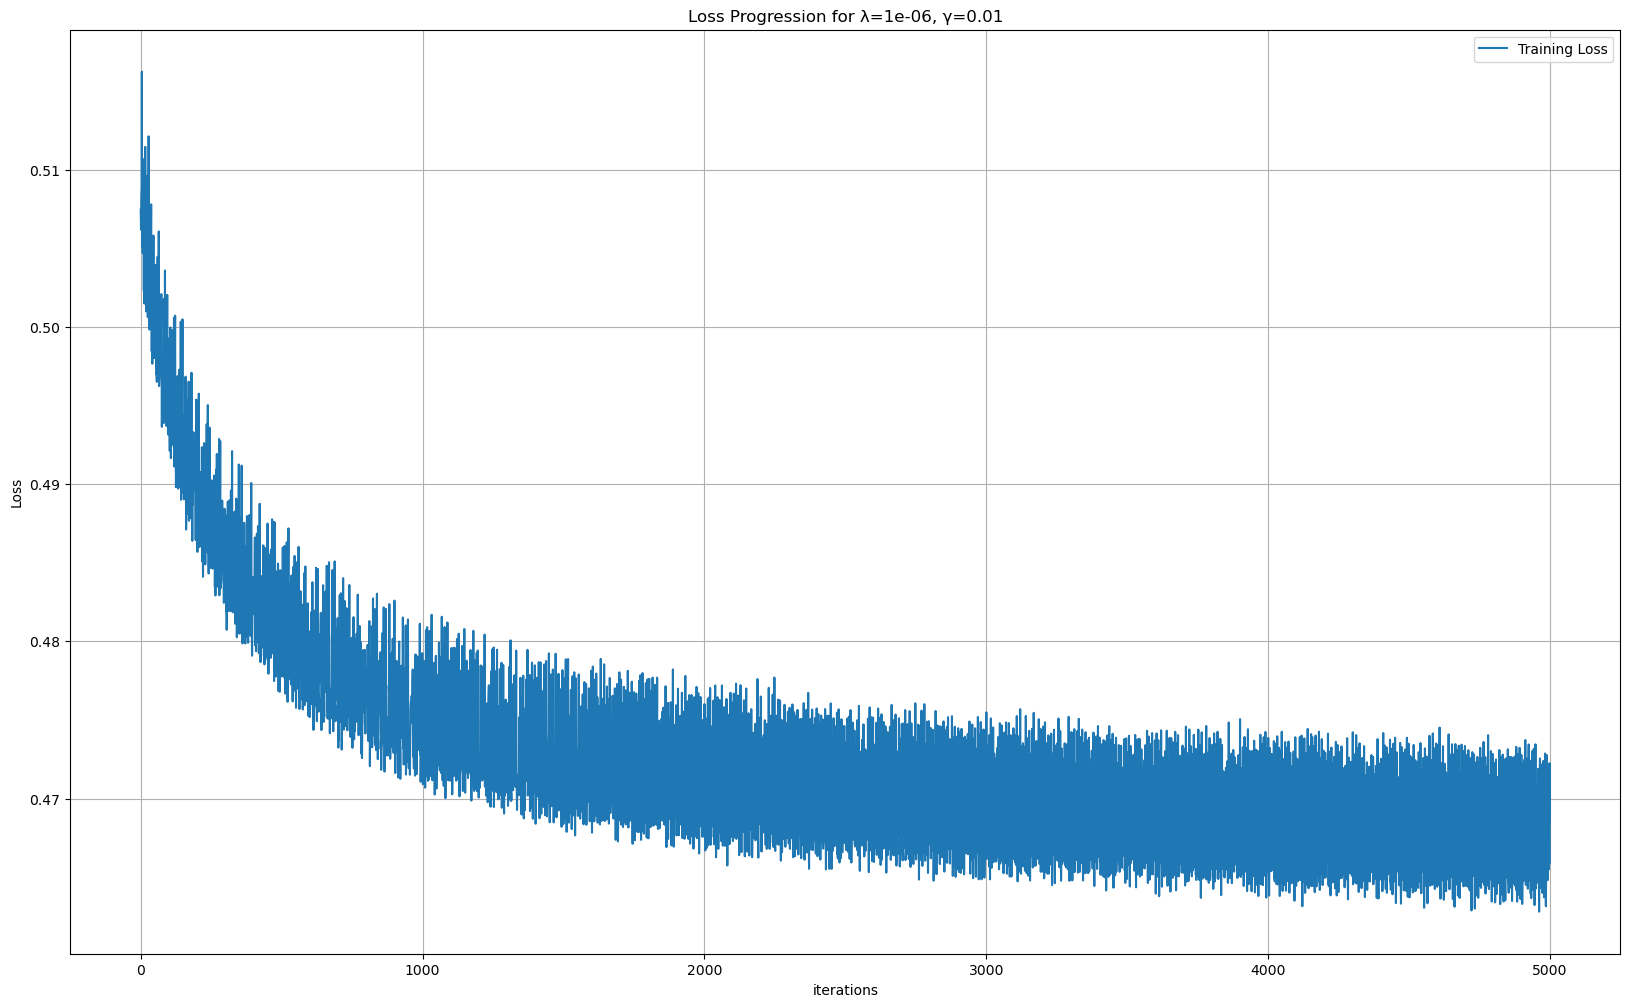

Achieved loss:  0.4658933509792349


In [12]:
training_max_iters = 5000
w, loss = reg_logistic_regression(ytrain_01, xtrain, best_lambda, best_w, training_max_iters, best_gamma,plot=True)
print("Achieved loss: ", loss)

In [13]:
print("Accuracy on undersampled data: ", accuracy(xtrain, ytrain, w))
best_threshold = find_best_threshold(xtrain,ytrain,w)
print(f"F1 score tuned on undersampled data:  {f1(xtrain, ytrain, w,best_threshold)} with threshold {best_threshold}")
print(f"F1 score on undersampled data:  {f1(xtrain, ytrain, w,0.5)} with threshold {0.5} \n")

print("original data accuracy: ", accuracy(imbalanced_x, y_train, w))
best_threshold = find_best_threshold(imbalanced_x,y_train,w)
print(f"original data f1 tuned: {f1(imbalanced_x, y_train, w,best_threshold)} with threshold {best_threshold}")
print(f"original data f1: {f1(imbalanced_x, y_train, w,0.5)} with threshold {0.5}")

Accuracy on undersampled data:  0.7231578947368421
F1 score tuned on undersampled data:  0.7973297305888897 with threshold 0.4080267558528428
F1 score on undersampled data:  0.7863332087396786 with threshold 0.5 

original data accuracy:  0.8739908878967498
original data f1 tuned: 0.4293461271864849 with threshold 0.7224080267558528
original data f1: 0.3782847147866315 with threshold 0.5


In [14]:
# Predict the labels of the test data and create the submission file.
y_pred = predict(w, xtest,best_threshold)
create_csv_submission(test_ids, y_pred, "submission.csv")